In [1]:
from geometry import *

In [88]:
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Dict, Any, Union, Callable, Set, TypeVar, Generic, Iterable, Iterator, Sequence, Mapping
from shapely.geometry import Polygon as ShapelyPolygon, Point as ShapelyPoint, LineString as ShapelyLineString, MultiPolygon as ShapelyMultiPolygon
import geopandas as gpd
import pandas as pd
import numpy as np
import random


In [90]:
@dataclass
class Shape:
    coords: Optional[List[Tuple[float, float]]] = field(default=None)
    data: Optional[dict] = None

    def to_gdf(self) -> gpd.GeoDataFrame:
        """Convert shape to a GeoDataFrame."""
        gdf_dict = self.data or {}  # Use data if provided
        gdf_dict["geometry"] = self.geometry
        return gpd.GeoDataFrame([gdf_dict])

@dataclass
class Polygon(Shape):
    origin: Optional[Tuple[float, float]] = None
    size: Optional[Tuple[float, float]] = None
    def __post_init__(self):
        if self.origin is not None and self.size is not None:
            self.coords = [
                self.origin,
                (self.origin[0] + self.size[0], self.origin[1]),
                (self.origin[0] + self.size[0], self.origin[1] + self.size[1]),
                (self.origin[0], self.origin[1] + self.size[1]),
            ]
        elif self.coords is not None:
            pass  # Use given coords
        else:
            raise ValueError("Must provide either `origin` and `size`, or `coords`.")
        
        self.geometry = ShapelyPolygon(self.coords)

    def split_grid(self, rows: int, cols: int) -> List['Polygon']:
        """Splits the polygon into a grid of `rows x cols` smaller polygons."""
        if self.size is None or self.origin is None:
            raise ValueError("Grid splitting requires `origin` and `size`.")

        width, height = self.size[0] / cols, self.size[1] / rows
        sub_polygons = []

        for i in range(rows):
            for j in range(cols):
                sub_origin = (self.origin[0] + j * width, self.origin[1] + i * height)
                sub_polygons.append(Polygon(origin=sub_origin, size=(width, height)))

        return sub_polygons


@dataclass
class MultiPolygon(Shape):
    polygons: List[Union['Polygon', List[List[float]]]] = None
    data: Dict = field(default_factory=dict)
    geometry: ShapelyMultiPolygon = field(init=False)

    def __post_init__(self):
        """Convert input into a valid Shapely MultiPolygon."""
        processed_polygons = []
        
        for item in self.polygons:
            if isinstance(item, Polygon):  # If a Polygon instance, use its geometry
                processed_polygons.append(item.geometry)
            elif isinstance(item, list):  # If a list of coordinates, create a Polygon
                processed_polygons.append(ShapelyPolygon(item))
            else:
                raise TypeError("MultiPolygon must be initialized with Polygon instances or coordinate lists.")

        self.geometry = ShapelyMultiPolygon(processed_polygons)


@dataclass
class Line(Shape):
    def __post_init__(self):
        if self.coords is None:
            raise ValueError("Must provide `coords`.")
        
        self.geometry = ShapelyLineString(self.coords)

In [93]:
multi_polygon = MultiPolygon(polygons=[
    Polygon(origin=(0, 0), size=(1, 1)),
    Polygon(origin=(4, 4), size=(1, 1))
], data={"name": "eample", "description": "A multi-polygon example"})

In [78]:
poly = Polygon(origin=(0, 0), size=(10,10), data={"name": "square", "color": "red", "size": 1})

In [81]:
sub_polygons = poly.split_grid(3, 3)
for i, sub in enumerate(sub_polygons):
    random_value = random.randint(0, 100)
    sub.data = {"name": f"{i}", "color": "blue", "size": random_value}

<Axes: >

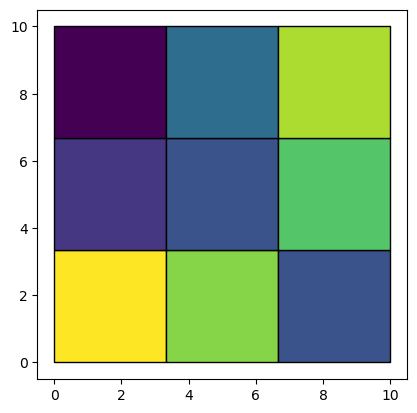

In [82]:

all_polys = pd.concat([p.to_gdf() for p in sub_polygons])
all_polys = all_polys.reset_index()
all_polys.plot('size', cmap='viridis', edgecolor='black')

In [44]:
poly.data["utils"] = False

In [46]:
poly.to_gdf()

,name,color,size,utils,geometry
0,square,red,1,False,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"


In [40]:
all_shapes = pd.concat([line.to_gdf(), poly.to_gdf()], ignore_index=True)
all_shapes

,name,color,size,geometry
0,line,red,2,"LINESTRING (0 0, 1 1)"
1,square,red,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"


In [28]:
poly.to_gdf()

,name,color,size,geometry
0,square,red,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"


In [29]:
poly

Polygon(coords=[(0, 0), (1, 0), (1, 1), (0, 1)], data={'name': 'square', 'color': 'red', 'size': 1, 'geometry': <POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))>}, origin=(0, 0), size=(1, 1))

In [ ]:
class mPolygon(Vector):
    def __init__(
        self, 
        origin: Optional[Tuple[float, float]] = None,
        coords: Optional[List[Tuple[float, float]]] = None,
        size: Optional[Tuple[float, float]] = None,
        color: Optional[str] = 'blue',
        alpha: Optional[float] = 0.5,
        **kwargs
        ):
        

        if origin is not None and size is not None:
            self.coords = [
                origin,
                (origin[0] + size[0], origin[1]),
                (origin[0] + size[0], origin[1] + size[1]),
                (origin[0], origin[1] + size[1]),
            ]
        elif coords is not None:
            self.coords = coords
        else:
            raise ValueError("Must provide either `origin` and `size`, or `coords`.")
            
        self.geometry = Polygon(self.coords)
        self.color = color
        self.alpha = alpha

        for key, value in kwargs.items():
            setattr(self, key, value)


